✅ Using device: cuda


Downloading...
From (original): https://drive.google.com/uc?id=1ndPlHN-SNNn0OwT6YAVIdhC285nUOQd0
From (redirected): https://drive.google.com/uc?id=1ndPlHN-SNNn0OwT6YAVIdhC285nUOQd0&confirm=t&uuid=9c5c425c-5caa-4ed6-997f-a4dca4e864a7
To: /content/chest_xray.zip
100%|██████████| 2.46G/2.46G [00:23<00:00, 104MB/s] 


Extracting dataset...
✅ Dataset Ready!
Classes: ['NORMAL', 'PNEUMONIA']


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 97.5MB/s]


Epoch 1/5 - TrainLoss: 0.150 | ValAcc: 62.50%
Epoch 2/5 - TrainLoss: 0.086 | ValAcc: 68.75%
Epoch 3/5 - TrainLoss: 0.062 | ValAcc: 75.00%
Epoch 4/5 - TrainLoss: 0.052 | ValAcc: 56.25%
Epoch 5/5 - TrainLoss: 0.038 | ValAcc: 93.75%

📊 Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.97      0.74      0.84       234
   PNEUMONIA       0.86      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



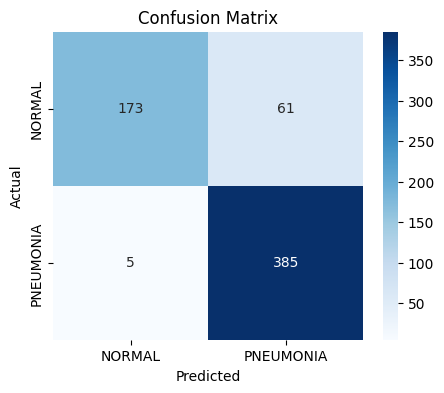

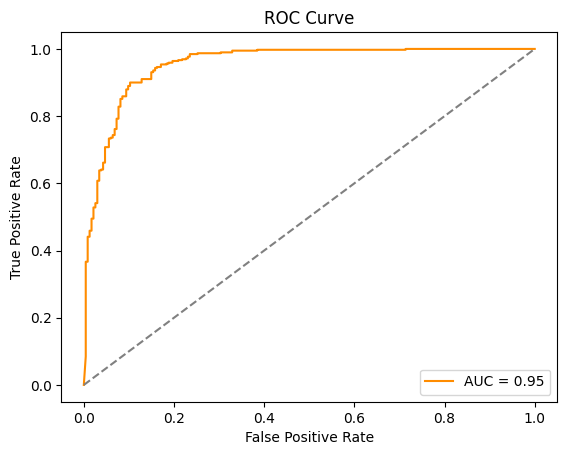


🩻 Generating pneumonia visualizations...

--- NORMAL CASE ---


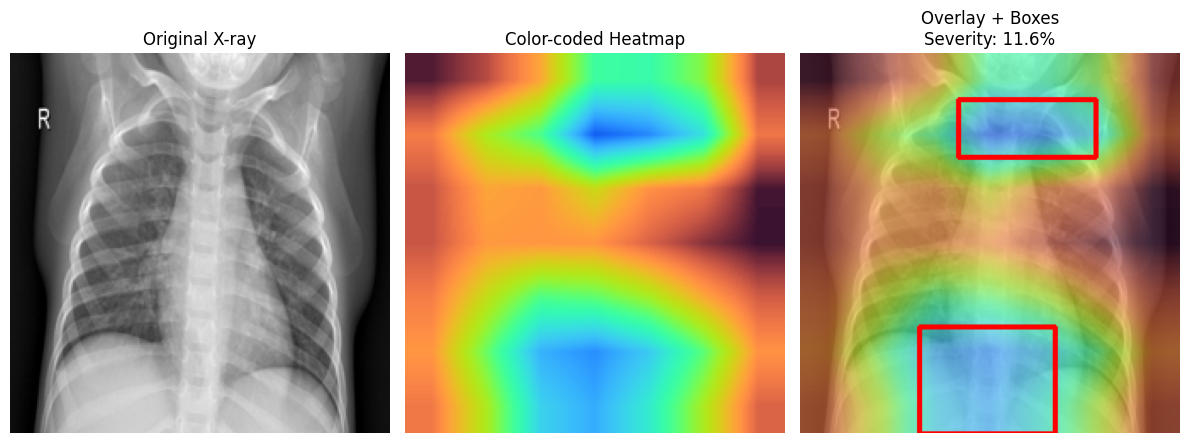

🧮 Severity: 11.60% of lung area
🟠 Moderate Infection

--- PNEUMONIA CASE ---


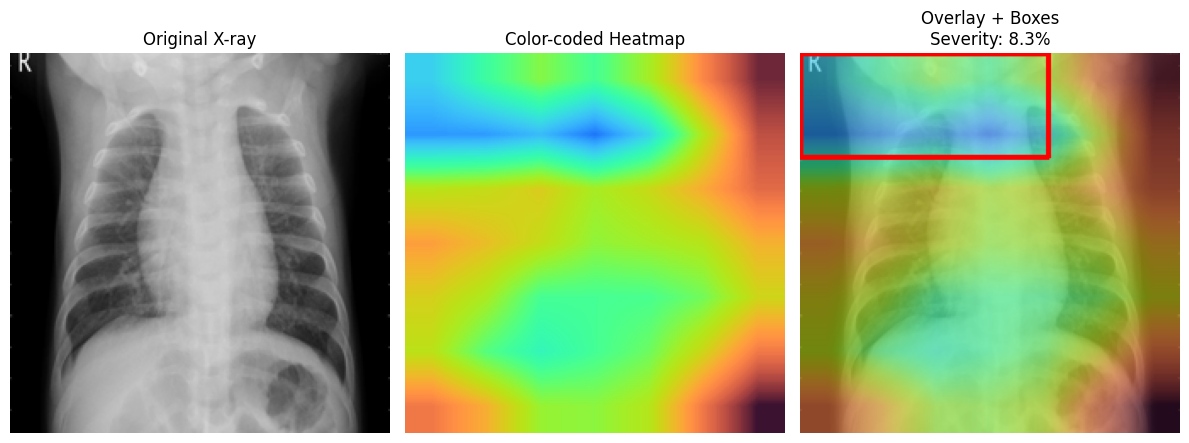

🧮 Severity: 8.26% of lung area
🟢 Mild / Likely Normal

✅ Model saved as pneumonia_model_final.pth


In [ ]:
# ==========================================================
# 🩺 Pneumonia Detection from Chest X-Rays using ResNet-18
# Includes Heatmap, Bounding Box, and Severity Analysis
# Made by: (Your Name)
# ==========================================================

!pip install torch torchvision matplotlib seaborn scikit-learn gdown --quiet

# --- Imports ---
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, os, cv2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# ------------------------------------------------------------
# 1. Download and extract dataset
# ------------------------------------------------------------
file_id = "1ndPlHN-SNNn0OwT6YAVIdhC285nUOQd0"
zip_path = "chest_xray.zip"
extract_path = "/content/chest_xray"

if not os.path.exists(zip_path):
    import gdown
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

import zipfile
if not os.path.exists(os.path.join(extract_path, "chest_xray")):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
print("✅ Dataset Ready!")

data_dir = "/content/chest_xray/chest_xray"

# ------------------------------------------------------------
# 2. Data transforms and loaders
# ------------------------------------------------------------
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(os.path.join(data_dir,"train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(data_dir,"val"),   transform=val_tfms)
test_ds  = datasets.ImageFolder(os.path.join(data_dir,"test"),  transform=val_tfms)

train_dl = DataLoader(train_ds,batch_size=16,shuffle=True)
val_dl   = DataLoader(val_ds,batch_size=16,shuffle=False)
test_dl  = DataLoader(test_ds,batch_size=16,shuffle=False)

class_names = train_ds.classes
print("Classes:", class_names)

# ------------------------------------------------------------
# 3. Model setup (ResNet-18 fine-tuned)
# ------------------------------------------------------------
model = models.resnet18(pretrained=True)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# ------------------------------------------------------------
# 4. Training loop
# ------------------------------------------------------------
epochs = 5
train_loss, val_acc = [], []

for e in range(epochs):
    model.train()
    running_loss = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = 100 * correct / total
    train_loss.append(running_loss/len(train_dl))
    val_acc.append(acc)
    print(f"Epoch {e+1}/{epochs} - TrainLoss: {train_loss[-1]:.3f} | ValAcc: {acc:.2f}%")

# ------------------------------------------------------------
# 5. Evaluation
# ------------------------------------------------------------
model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        probs = torch.softmax(out, dim=1)[:,1]
        y_pred.extend(out.argmax(1).cpu().numpy())
        y_true.extend(y.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

print("\n📊 Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(); plt.show()

# ------------------------------------------------------------
# 6. Enhanced Visualization: Heatmap + Bounding Box + Severity
# ------------------------------------------------------------
print("\n🩻 Generating pneumonia visualizations...")

def visualize_pneumonia(img_path):
    img = Image.open(img_path).convert("RGB")
    tfm = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    inp = tfm(img).unsqueeze(0).to(device)

    # Get feature maps from layer4
    x = inp
    for name, layer in list(model._modules.items())[:-2]:
        x = layer(x)
    fmap = x[0].detach().cpu().numpy()
    fmap = np.mean(fmap, axis=0)
    fmap = (fmap - fmap.min()) / (fmap.max() + 1e-8)
    fmap = cv2.resize(fmap, (224,224))

    img_np = np.array(img.resize((224,224)))

    # Create color-coded heatmap (Turbo colormap)
    colored_map = cv2.applyColorMap(np.uint8(255*fmap), cv2.COLORMAP_TURBO)

    # Detect high-activation (infection) regions
    thresh = (fmap > 0.6).astype(np.uint8) * 255
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    overlay = np.uint8(0.6*colored_map + 0.4*img_np)
    for c in contours:
        if cv2.contourArea(c) > 50:
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(overlay, (x,y), (x+w,y+h), (255,0,0), 2)

    # Severity estimation
    infected = np.sum(fmap > 0.6)
    total = fmap.size
    severity = (infected / total) * 100

    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original X-ray"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(colored_map); plt.title("Color-coded Heatmap"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay + Boxes\nSeverity: {severity:.1f}%"); plt.axis("off")
    plt.tight_layout()
    plt.show()

    print(f"🧮 Severity: {severity:.2f}% of lung area")
    if severity < 10:
        print("🟢 Mild / Likely Normal")
    elif severity < 35:
        print("🟠 Moderate Infection")
    else:
        print("🔴 Severe Pneumonia Suspected")

# Test for both Normal and Pneumonia
normal_img = os.path.join(f"{data_dir}/test/NORMAL", os.listdir(f"{data_dir}/test/NORMAL")[0])
pneumonia_img = os.path.join(f"{data_dir}/test/PNEUMONIA", os.listdir(f"{data_dir}/test/PNEUMONIA")[0])

print("\n--- NORMAL CASE ---")
visualize_pneumonia(normal_img)

print("\n--- PNEUMONIA CASE ---")
visualize_pneumonia(pneumonia_img)

# ------------------------------------------------------------
# 7. Save model
# ------------------------------------------------------------
torch.save(model.state_dict(), "pneumonia_model_final.pth")
print("\n✅ Model saved as pneumonia_model_final.pth")